In [3]:
import numpy as np
from skimage import color, filters
import matplotlib.pyplot as plt
from skimage import io
import cv as cv


#II. Nội dung:


##1. Seam Carving:


a) Tính toán năng lượng của ảnh:


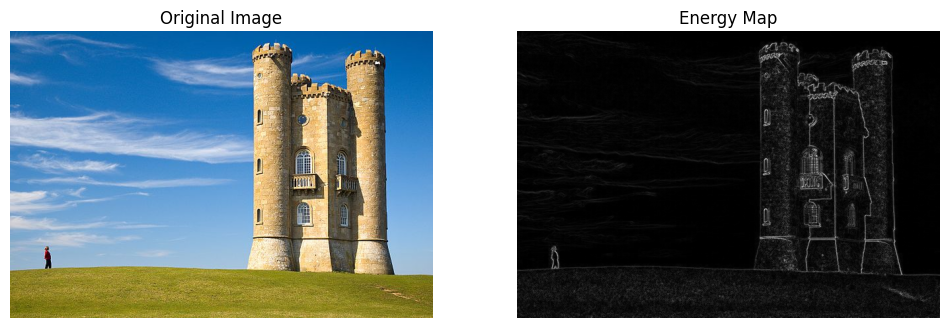

In [4]:

def energy_function(image):

	H, W, _ = image.shape
	out = np.zeros((H, W))

	image = color.rgb2gray(image)
	out_y, out_x = np.gradient(image)
	out = abs(out_y)+abs(out_x)

	return out
image_path = 'castle.jpg'
image = io.imread(image_path)

energy_map = energy_function(image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(image)
ax1.set_title("Original Image")
ax1.axis("off")

ax2.imshow(energy_map, cmap='gray')
ax2.set_title("Energy Map")
ax2.axis("off")

plt.show()

b) Tìm chi phí thấp nhất tại từng điểm ảnh:


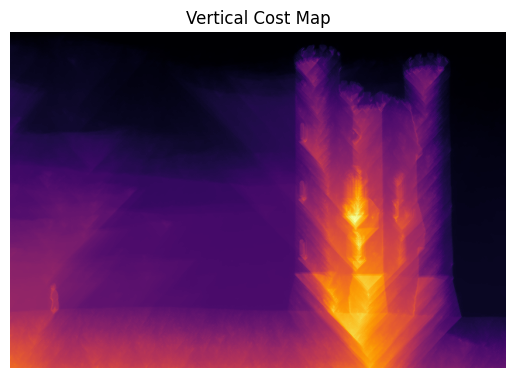

In [5]:
def compute_cost(image, energy, axis=1):

	energy = energy.copy()

	if axis == 0:
		energy = np.transpose(energy, (1, 0))

	H, W = energy.shape

	cost = np.zeros((H, W))
	paths = np.zeros((H, W), dtype=int)

	cost[0] = energy[0]
	paths[0] = 0

	for i in range(1,H):
		left_neighbor = np.insert(cost[i-1,0:W-1], 0, 1e10)
		upper_neighbor = cost[i-1]
		right_neighbor = np.insert(cost[i-1,1:W], W-1, 1e10)
		pixel_neighbors = np.vstack([left_neighbor,upper_neighbor,right_neighbor])
		cost[i] = energy[i]+np.min(pixel_neighbors, axis=0)
		paths[i] = np.argmin(pixel_neighbors, axis=0)-1

	if axis == 0:
		cost = np.transpose(cost, (1, 0))
		paths = np.transpose(paths, (1, 0))

	assert np.all(np.any([paths == 1, paths == 0, paths == -1], axis=0)), \
		   "paths contains other values than -1, 0 or 1"

	return cost, paths

img = io.imread('castle.jpg')
energy = energy_function(img)


vcost, _ = compute_cost(img, energy, axis=1)
plt.title('Vertical Cost Map')
plt.axis('off')
plt.imshow(vcost, cmap='inferno')
plt.show()

c) Tìm đường seam:


Seam Energy 2.432365490196077


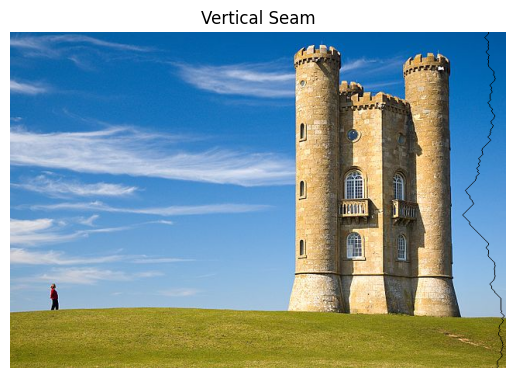

In [6]:
def backtrack_seam(paths, end):
	H, W = paths.shape
	seam = np.zeros(H, dtype=int)

	seam[H-1] = end

	for i in range(H-2,0,-1):
		seam[i] = seam[i+1]+paths[i+1,seam[i+1]]
	seam[0] = seam[1]+paths[1,seam[1]]

	assert np.all(np.all([seam >= 0, seam < W], axis=0)), "seam contains values out of bounds"
	return seam


vcost, vpaths = compute_cost(img, energy)

end = np.argmin(vcost[-1])
seam_energy = vcost[-1, end]
seam = backtrack_seam(vpaths, end)

print('Seam Energy', seam_energy)

vseam = np.copy(img)
for row in range(vseam.shape[0]):
  vseam[row, seam[row], :] = np.array([1.0, 0, 0])

plt.title('Vertical Seam')
plt.axis('off')
plt.imshow(vseam)
plt.show()


d) Loại bỏ đường seam:


In [7]:
def remove_seam(image, seam):
  if len(image.shape) == 2:
    image = np.expand_dims(image, axis=2)
  out = None
  H, W, C = image.shape
  out = np.zeros((H, W-1, C), dtype=type(image[0, 0, 0]))

  for i in range(H):
    out[i, 0:seam[i], 0:C] = image[i, 0:seam[i], 0:C].copy()
    out[i, seam[i]:, 0:C] = image[i, seam[i]+1:, 0:C].copy()

  out = np.squeeze(out)
  return out

● Cài đặt hàm reduce để giảm kích thước ảnh:


In [8]:
def reduce(image, size, axis=1, efunc=energy_function, cfunc=compute_cost):
  out = np.copy(image)
  if axis == 0:
    out = np.transpose(out, (1, 0, 2))
  H = out.shape[0]
  W = out.shape[1]

  assert W > size, "Size must be smaller than %d" % W

  assert size > 0, "Size must be greater than zero"

  loop = W - size
  for i in range(loop):
    _cost, _path = cfunc(out, efunc(out))
    _seam = backtrack_seam(_path, np.argmin(_cost[-1]))
    out = remove_seam(out, _seam).copy()
  assert out.shape[1] == size, "Output doesn't have the right shape"

  if axis == 0:
    out = np.transpose(out, (1, 0, 2))

  return out

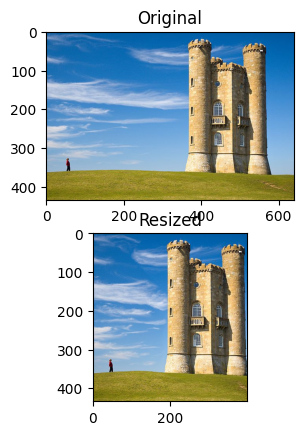

In [9]:
H, W, _ = img.shape
W_new = 400

out = reduce(img, W_new)

# print("Reducing width from %d to %d: %f seconds." %(W, W_new, end - start))

plt.subplot(211)
plt.title('Original')
plt.imshow(img)

plt.subplot(212)
plt.title('Resized')
plt.imshow(out)
plt.show()


##2. Các phương pháp trích xuất đặt trưng:
a) Sift:

In [23]:
# def detect_keypoints(magnitude, threshold=10.0, edge_size=8):
#   keypoints = []
#   h, w = magnitude.shape
#   for y in range(edge_size, h-edge_size):
#     for x in range(edge_size, w-edge_size):
#       if magnitude[y, x] > threshold:
#         keypoints.append((x, y))
#   return keypoints
def detect_keypoints(magnitude, threshold=10.0, edge_size=8):
    keypoints = []
    h, w = magnitude.shape
    for y in range(edge_size, h - edge_size):
        for x in range(edge_size, w - edge_size):
            if magnitude[y, x] > threshold:
                keypoints.append((x, y))
    return keypoints

In [24]:
# def compute_histogram(patch_ori, patch_mag, bins=8, range_bins=(-180, 180)):
#   histogram = [0] * bins
#   bin_size = (range_bins[1] - range_bins[0]) / bins

#   for i in range(patch_ori.shape[0]):
#     for j in range(patch_ori.shape[1]):
#       ori = patch_ori[i, j]
#       mag = patch_mag[i, j]
#       bin_index = int((ori - range_bins[0]) / bin_size)

#       bin_index = min(max(bin_index, 0), bins -1)

#       histogram[bin_index] += mag

#   return histogram

def compute_histogram(patch_ori, patch_mag, bins=8, range_bins=(-180, 180)):
    histogram = [0] * bins
    bin_size = (range_bins[1] - range_bins[0]) / bins

    for i in range(patch_ori.shape[0]):
        for j in range(patch_ori.shape[1]):
            ori = patch_ori[i, j]
            mag = patch_mag[i, j]
            bin_index = int((ori - range_bins[0]) / bin_size)
            bin_index = min(max(bin_index, 0), bins - 1)
            histogram[bin_index] += mag
    return histogram

In [26]:
# def compute_descriptors(keypoints, magnitude, orientations):
#   descriptors = []
#   for kp in keypoints:
#     y, x = kp
#     patch_mag = magnitude[y-8:y+8, x-8:x+8]
#     patch_ori = orientations[y-8:y+8, x-8:x+8]
#     hist = compute_histogram(patch_ori, patch_mag, bins=8, range_bins=(-180, 180))
#     descriptors.append(hist)
#   return np.array(descriptors)
def compute_descriptors(keypoints, magnitude, orientation):
    descriptors = []
    for kp in keypoints:
        y, x = kp
        patch_mag = magnitude[y-8:y+8, x-8:x+8]
        patch_ori = orientation[y-8:y+8, x-8:x+8]

        # Divide the patch into 4x4 subregions
        descriptor = []
        for i in range(0, 16, 4):
            for j in range(0, 16, 4):
                sub_patch_mag = patch_mag[i:i+4, j:j+4]
                sub_patch_ori = patch_ori[i:i+4, j:j+4]
                hist = compute_histogram(sub_patch_ori, sub_patch_mag, bins=8, range_bins=(-180, 180))
                descriptor.extend(hist)

        # Normalize descriptor to have unit length
        descriptor = np.array(descriptor)
        descriptor /= np.linalg.norm(descriptor) + 1e-7  # Avoid division by zero

        descriptors.append(descriptor)

    return np.array(descriptors)



In [27]:
# def draw_keypoints(image, keypoints):
#   img_keypoints = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
#   for kp in keypoints:
#     cv.circle(img_keypoints, (kp[1], kp[0]), 3, (0, 0, 255), 1)
#   return img_keypoints
def draw_keypoints(image, keypoints):
    img_keypoints = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
    for kp in keypoints:
        cv.circle(img_keypoints, (kp[1], kp[0]), 3, (0, 0, 255), 1)
    return img_keypoints

In [28]:
# def compute_gradients(image):
#     gx = filters.sobel_h(image)
#     gy = filters.sobel_v(image)
#     magnitude = np.sqrt(gx**2 + gy**2)
#     orientation = np.arctan2(gy, gx) * (180 / np.pi)
#     return magnitude, orientation
def compute_gradients(image):
    gx = filters.sobel_h(image)
    gy = filters.sobel_v(image)
    magnitude = np.sqrt(gx**2 + gy**2)
    orientation = np.arctan2(gy, gx) * (180 / np.pi)  # Convert radians to degrees
    return magnitude, orientation


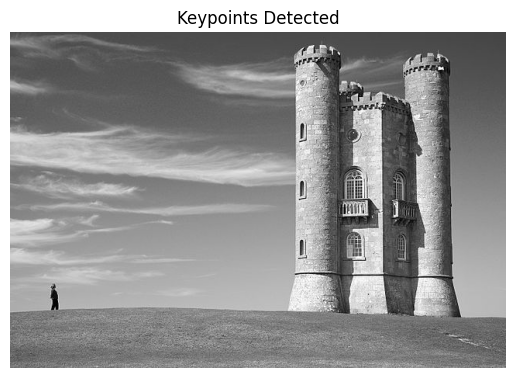

In [30]:
def SIFT():
    imgPath = 'castle.jpg'
    imgGray = cv.imread(imgPath, cv.IMREAD_GRAYSCALE)

    if imgGray is None:
        print('Error: Image not found')
        return

    magnitude, orientation = compute_gradients(imgGray)
    keypoints = detect_keypoints(magnitude, threshold=10.0)
    descriptors = compute_descriptors(keypoints, magnitude, orientation)
    imgKeypoints = draw_keypoints(imgGray, keypoints)

    plt.figure()
    plt.imshow(imgKeypoints, cmap='gray')
    plt.title('Keypoints Detected')
    plt.axis('off')
    plt.show()

if __name__ == '__main__':
    SIFT()

In [16]:
def compute_gradients(image):
    if len(image.shape) == 3:
        gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    else:
        gray_image = image

    grad_x = cv.Sobel(gray_image, cv.CV_64F, 1, 0, ksize=3)
    grad_y = cv.Sobel(gray_image, cv.CV_64F, 0, 1, ksize=3)

    magnitude = np.sqrt(grad_x**2 + grad_y**2)

    orientation = (np.arctan2(grad_y, grad_x) * 180) / np.pi

    orientation = np.degrees(orientation) % 180

    return magnitude, orientation

In [31]:
def compute_histogram(mag, ang, cell_size, nbins):
  h, w= mag.shape
  n_cells_x = w // cell_size
  n_cells_y = h // cell_size
  hist = np.zeros((n_cells_y, n_cells_x, nbins))

  bin_width = 180.0 / nbins

  for i in range(n_cells_y):
      for j in range(n_cells_x):
        cell_mag = mag[i*cell_size:(i+1) * cell_size, j*cell_size:(j+1) * cell_size]
        cell_ang = ang[i*cell_size:(i+1) * cell_size, j*cell_size:(j+1) * cell_size]
        hist[i,j] = np.histogram(cell_ang, bins=nbins, range=(0,180), weights = cell_mag)[0]
  return hist

In [32]:
def normalize_histograms(hist, block_size, nbins):
  h, w, _ = hist.shape
  n_blocks_y = h - block_size + 1
  n_blocks_x = w - block_size + 1
  normalized_hist = np.zeros((n_blocks_y, n_blocks_x, block_size, block_size, nbins))
  for i in range(n_blocks_y):
    for j in range(n_blocks_x):
      block = hist[i:i+block_size, j:j+block_size].flatten()
      norm = np.sqrt(np.sum(block**2) + 1e-6)
      normalized_block = block / norm
      normalized_hist[i,j] = normalized_block.reshape(block_size, block_size, nbins)
  return normalized_hist

In [35]:
def hog_segmentation(image):
  gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

  mag, ang = compute_gradients(gray)

  cell_size = 8
  block_size = 2
  nbins = 9

  hist = compute_histogram(mag, ang, cell_size, nbins)

  normalized_hist = normalize_histograms(hist, block_size, nbins)

  energy = np.sum(hist, axis=2)
  energy_resized = cv.resize(energy, (gray.shape[1], gray.shape[0]))
  threshold = np.mean(energy_resized)
  mask = np.zeros_like(gray)

  mask[energy_resized > threshold] = 255

  kernel = np.ones((5,5), np.uint8)
  mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)
  mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)

  segmented_image = cv.bitwise_and(image, image, mask=mask)
  return segmented_image


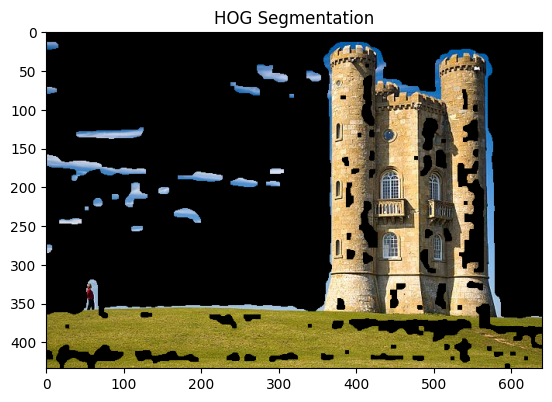

In [36]:
segmented_image = hog_segmentation(img)
plt.figure()
plt.imshow(segmented_image)
plt.title("HOG Segmentation")
plt.show()

#III. Bài tập:


1. Tạo hàm duplicate_seam (Tương tự hàm remove_seam).


In [17]:
def duplicate_seam(image, seam):
	H, W, C = image.shape
	out = np.zeros((H, W + 1, C), dtype=type(image[0, 0, 0]))
	for i in range(H):
		out[i,0:seam[i]+1,0:C] = image[i,0:seam[i]+1,0:C].copy()
		out[i,seam[i]+1:,0:C] = image[i,seam[i]:,0:C].copy()

	return out


In [18]:
def enlarge_naive(image, size, axis=1, efunc=energy_function, cfunc=compute_cost):

	out = np.copy(image)
	if axis == 0:
		out = np.transpose(out, (1, 0, 2))
	H = out.shape[0]
	W = out.shape[1]
	assert size > W, "size must be greather than %d" % W
	loop = size - W
	for i in range(loop):
		_cost, _path = cfunc(out,efunc(out))
		_seam = backtrack_seam(_path,np.argmin(_cost[-1]))
		out = duplicate_seam(out,_seam).copy()
	if axis == 0:
		out = np.transpose(out, (1, 0, 2))

	return out


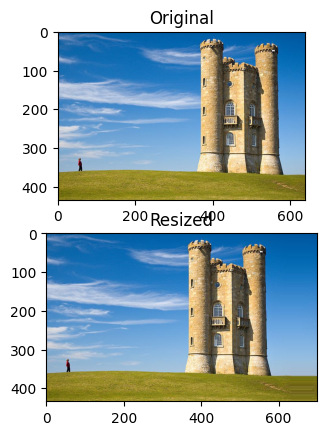

In [19]:
image = io.imread('castle.jpg')
H, W, _ = image.shape

W_new = 700
energy = energy_function(image)

out = enlarge_naive(image, W_new, axis=1)
plt.subplot(211)
plt.title('Original')
plt.imshow(img)

plt.subplot(212)
plt.title('Resized')
plt.imshow(out)
plt.show()


In [20]:
def find_seams(image, k, axis=1, efunc=energy_function, cfunc=compute_cost):

	image = np.copy(image)
	if axis == 0:
		image = np.transpose(image, (1, 0, 2))
	H, W, C = image.shape
	assert W > k, "k must be smaller than %d" % W

	indices = np.tile(range(W), (H, 1))

	seams = np.zeros((H, W), dtype=type(image[0, 0, 0]))

	for i in range(k):
		energy = efunc(image)
		cost, paths = cfunc(image, energy)
		end = np.argmin(cost[H - 1])
		seam = backtrack_seam(paths, end)

		image = remove_seam(image, seam)


		assert np.all(seams[np.arange(H), indices[np.arange(H), seam]] == 0), \
			"we are overwriting seams"
		seams[np.arange(H), indices[np.arange(H), seam]] = i + 1

		indices = remove_seam(indices, seam)

	if axis == 0:
		seams = np.transpose(seams, (1, 0))
	return seams


In [21]:
def enlarge(image, size, axis=1, efunc=energy_function, cfunc=compute_cost):

	out = np.copy(image)
	if axis == 0:
		out = np.transpose(out, (1, 0, 2))
	H, W, C = out.shape

	assert size > W, "size must be greather than %d" % W

	assert size <= 2 * W, "size must be smaller than %d" % (2 * W)

	k = size - W
	seams = find_seams(out,k,efunc=energy_function,cfunc=compute_cost)
	temp = np.zeros((H,size,C), dtype=type(image[0, 0, 0]))
	for i in range(H):
		z = np.where(seams[i]>0)[0]
		dupe = []
		for j in z:
			dupe.append(out[i,j])
		temp[i] = np.insert(out[i],z,dupe,axis=0)
	out = np.copy(temp)

	if axis == 0:
		out = np.transpose(out, (1, 0, 2))

	return out


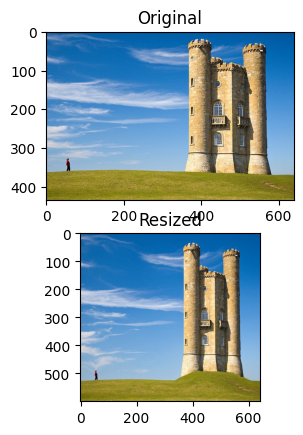

In [22]:
image = io.imread('castle.jpg')
H, W, _ = image.shape

W_new = 600
energy = energy_function(image)

out = enlarge(image, W_new, axis=0)
plt.subplot(211)
plt.title('Original')
plt.imshow(img)

plt.subplot(212)
plt.title('Resized')
plt.imshow(out)
plt.show()

In [37]:
def detect_and_match_features_sift_knn(template_path, target_path):
    template = cv.imread(template_path)
    target = cv.imread(target_path)

    template = cv.cvtColor(template, cv.COLOR_BGR2RGB)
    target = cv.cvtColor(target, cv.COLOR_BGR2RGB)

    sift = cv.SIFT_create()
    keypoints_template, descriptors_template = sift.detectAndCompute(template, None)
    keypoints_target, descriptors_target = sift.detectAndCompute(target, None)

    bf = cv.BFMatcher()
    knn_matches = bf.knnMatch(descriptors_template, descriptors_target, k=2)

    good_matches = []
    for m, n in knn_matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    if len(good_matches) > 10:
        src_pts = np.float32([keypoints_template[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_target[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)

        h, w = template.shape[:2]
        corners = np.array([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]], dtype='float32').reshape(-1, 1, 2)
        transformed_corners = cv.perspectiveTransform(corners, M)

        x, y, w, h = cv.boundingRect(np.int32(transformed_corners))

        cv.rectangle(target, (x, y), (x + w, y + h), (0, 255, 0), 2)

        plt.figure(figsize=(10, 6))
        plt.imshow(target)
        plt.title("Detected Object with Bounding Box")
        plt.show()
    else:
        print("Not enough matches found.")

template_path = 'target.png'
target_path = 'castle.jpg'
detect_and_match_features_sift_knn(template_path, target_path)

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
